### DSI Capstone Project:
# Sentiment Analysis on NTUC Fairprice Mobile App
---
*Esther Leung Sau Yee (GA DSI 16)*

<img src="./images/ntucfp_ec.jpg" width="600">

# Problem Statement

### "How Might We Improve NTUC Fairprice Mobile App User Experience to Boost Online Grocery Sales?"

**NTUC Fairprice** is Singapore's homegrown supermarket chain, and is named the [**top Singapore local brand**](https://www.campaignasia.com/article/singapores-top-local-brands-ntuc-fairprice-and-dbs-champion-nationalistic-spiri/463305) in Campaign Asia's Top 1000 Brands in 2020.

In **first half of 2020**, with the spread of **Covid-19** and the implementation of **circuit breaker and social distancing measures** in Singapore, [**supermarket sales was brisk**](https://www.dbs.com.sg/sme/aics/templatedata/article/generic/data/en/GR/042020/200406_insights_singapore_consumer.xml) according to DBS Group Research. **Online grocery sales** has grown tremendously over the past decade, and DBS estimated the size of online grocery market at S$600 million in January 2020 before Covid-19. 

<img src="./images/online grocery market.png" width="350" align="left">

With Covid-19, the **proportion of online sales in the Supermarket category** has increased according to Singstats, from **7.5%** in [March 2020](https://www.singstat.gov.sg/-/media/files/news/mrsmar2020.pdf) to **11.7%** in [August 2020](https://www.singstat.gov.sg/-/media/files/news/mrsaug2020.pdf). NTUC Fairprice capitalized on the growth in online grocery market by [launching its e-commerce mobile applications in the year 2015](https://www.todayonline.com/shop-go-ntuc-fairprice) as part of its digital strategy. With panick buying and the sudden surge in demand at the start of Covid-19, [the NTUC Fairprice app topped as the number one app on Apple AppStore](https://mustsharenews.com/ntuc-fairprice-app-store/) on 8 Feb 2020 following capacity issues with the NTUC online shopping website.

<img src="./images/ntuc_number1.png" width="250" align="left">

Even with subsequent [increase in online capacity](https://www.channelnewsasia.com/news/singapore/ntuc-fairprice-online-service-delivery-fee-covid-19-12647142), it is clear that NTUC Fairprice needs to **ride the growth the online grocery market** by **identifying negative reviews or sentiments** on the NTUC Fairprice mobile app for **prompt follow up action**, and **improve overall mobile app customer experience** by identifying customers' **pain points**, and the **values sought** from the mobile app usage.

As such, in this project, I aim to:

1. Build a **classification model** for positive vs. negative reviews
2. Apply **topic modelling** to identify consumers' pain points from negative reviews

# Executive Summary

#### 1. Text classification to identify negative reviews for prompt follow up
Based on evaluation of the variou classification models built, the production model is a **Voting Classifier** consisting of an ensemble of a **Multinomial NB model and Logistic Regression model**, with features extracted using the **TfidfVectorizer**. 

Given its **relatively high accuracy (0.88) and recall (0.89) on the test data**, we can conclude that the model generalises well on unseen data, and can be used to **identify negative reviews** for NTUC Fairprice mobile app, which can **allow for prompt follow up and service recovery**.

The web app of the classification model is deployed on [Heroku](https://sentiment-classification-ntuc.herokuapp.com/).

#### 2. Topic modelling to identify customer pain points for improvement opportunities
Based the **topic modelling using LDA**, the 3 main customer pain points identified are:

1. **Bugs/ Laggy interface**
2. **Out-of-stock/ No delivery slot**
3. **Payment/ Credit card issues**

Based on these pain points on the user journey, it can be seen that **poor customer experience leans towards the later part of the user journey**, leading to **abandon carts** and **loss of revenue**.

*User Journey Mapping*

<img src="./images/user journey.png" width="600" align="left">

The NTUC Fairprice mobile app team can look into ways to improve customer experience, by prioritising 2 aspects:

1. App development team - To focus on ensuring that app is not laggy in times of high loads, and rectify issues such as items disappearing from carts and payment errors.
2. Operations & supply chain team - To focus on inventory management, and improve delivery capacity, either through expanding delivery team or engaging third party logistics support.

This project is organised into 2 Jupyter notebooks. In this first notebook **"1_data_collection_and_eda"**, I will focus on:

* [1. Data Collection through Webscraping](#1.-Data-Collection)
* [2. Preliminary Exploratory Data Analysis](#2.-Preliminary-Exploratory-Data-Analysis)
* [3. VADER Sentiment Analysis](#3.-VADER-Sentiment-Analysis)
* [4. Text Preprocessing & Further Exploratory Data Analysis](#4.-Text-Preprocessing-&-Further-Exploratory-Data-Analysis)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import requests
import time
import random
from pathlib import Path
import regex as re

from google_play_scraper import Sort, reviews, reviews_all
from app_store_scraper import AppStore
from pprint import pprint

from bs4 import BeautifulSoup
from nltk.corpus import wordnet, stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-muted')

%matplotlib inline

# 1. Data Collection

The NTUC Fairprice mobile app is listed on both the **Google Play Store** and **Apple AppStore**. 

In both platforms, user can give the app a rating based on 5-point scale (with 5 being the highest, and 1 being the lowest). The rating can also be accompanied by a text review.

At the end of the data collection and merging from the 2 platforms, the dataset contains the following features:

| Features | Description |
|:--- | :--- |
| date | Date and time of review |
| review | User review on the mobile app |
| rating | User rating on the mobile app (1 to 5, with 5 is highest and 1 is lowest) |
| user | Username |
| source | Source of review (Google Play Store or Apple AppStore) | 

## 1.1 Data Collection from Google Play Store

The NTUC Fairprice app review data from Google Play Store is scraped using the [Google Play Scraper](https://pypi.org/project/google-play-scraper/) API.

In [2]:
# check if data file exists
data = Path('./data/ntuc_reviews_googleplay.csv')

# if data file exists, read the file
if data.is_file():
    googleplay_reviews = pd.read_csv('./data/ntuc_reviews_googleplay.csv')

# else, extract data from google play
else: 
    reviews_list = []
    for score in range(1,6):
        results = reviews_all('com.fairprice.mcomapp', 
                             sleep_milliseconds=0, # defaults to 0
                             lang='en', # defaults to 'en'
                             country='sg', # defaults to 'us'
                             sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
                             filter_score_with=score # defaults to None(means all score)
                            )

        reviews_list.extend(results)
        num_reviews = len(results)
        print(f"Number of reviews collected for rating {score}: {num_reviews}")
        
        # generate a random sleep duration to be 'polite'
        sleep_duration = random.randint(2, 4)
        time.sleep(sleep_duration)
                
        if score > 1:
            prev_df = pd.read_csv('./data/ntuc_reviews_googleplay.csv')
            current_df = pd.DataFrame(results)
            pd.concat([prev_df, current_df], axis=0).to_csv('./data/ntuc_reviews_googleplay.csv', index=False)
        else:
            pd.DataFrame(results).to_csv('./data/ntuc_reviews_googleplay.csv', index=False)
            

In [3]:
googleplay_reviews.shape

(2937, 10)

A total of 2937 records were scraped from the Google Play Store.

In [4]:
googleplay_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGzMPT7pOkahkS11GOAG2KXhMnX_6PV3yo5ZKT...,Monish Punekar,https://lh3.googleusercontent.com/a-/AOh14GhXc...,Not a good experience for first timer. Login a...,1,0,4.25.1,2020-09-11 13:47:35,NaN,NaN
1,gp:AOqpTOFrXELECCelLQLBH2LS3K5pkmv_FI7RWUC6sT8...,yt ng,https://play-lh.googleusercontent.com/-ncWbnEY...,One of the lousiest app! Tried using it severa...,1,16,4.19.0,2020-07-31 21:04:24,NaN,NaN
2,gp:AOqpTOHJdpI0oU4Ba8CwtaxvgCRfGFiySfYfcwuA44g...,Nathanael Lim,https://play-lh.googleusercontent.com/-O5UYZZS...,Lousy app. Cannot find most items using brand ...,1,0,4.25.1,2020-09-06 08:10:27,NaN,NaN
3,gp:AOqpTOFho2zPWFdItAsnEHmbe66OGXvspjSiwteCyrM...,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,NEW : GETS BETTER AND BETTER - MY LISTS DON'T ...,1,26,4.14.0,2020-06-25 00:07:48,"Hi there, we are constantly improving our app ...",2019-01-02 11:52:12
4,gp:AOqpTOFD18_3Wu_9al_m_-nd35tW6MXUu0D3c1A41ex...,Desmond Tan,https://lh3.googleusercontent.com/a-/AOh14GiMx...,The app would have gotten a 4 stars from me ex...,1,12,4.16.0,2020-07-19 12:43:30,NaN,NaN


As seen above, each record contains information such as the date and time of review ('at), the user who reviewed ('userName'), the users' rating ('score), and the text review ('content').

Let's check for any duplicates.

In [5]:
googleplay_reviews.duplicated(subset=['content']).sum()

358

In [6]:
googleplay_reviews[googleplay_reviews.duplicated(subset=['content'])].head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
573,gp:AOqpTOGlKrTNZt_Xr9OBNT3mH5Y0_WqPpi3I48j4QAd...,J L Cheng,https://lh3.googleusercontent.com/a-/AOh14GijA...,Useless app,1,0,NaN,2018-03-13 18:47:33,NaN,NaN
574,gp:AOqpTOEn85ZOeWotOAciBCQ0gzKfG9JBIeFxeItm5Bh...,Rainie Lim,https://play-lh.googleusercontent.com/-hBOqgPu...,Useless app,1,0,NaN,2019-08-19 18:09:14,NaN,NaN
699,gp:AOqpTOHDeuTbSBouginvebgz6gOby6G8ioQt6IhJVWq...,CS H,https://play-lh.googleusercontent.com/-Hek65jF...,not user friendly,2,1,2.1.20,2019-05-04 23:16:27,NaN,NaN
775,gp:AOqpTOHCXuEhPeqPIXLhs3HSMPIf8tEWzvrG_CRLKtr...,Antoni Sim,https://play-lh.googleusercontent.com/--j-Mkvk...,Not user friendly,2,0,1.2.7,2018-01-09 09:17:43,NaN,NaN
778,gp:AOqpTOFQe_O_Ie5AJp2MC0G2z_wDC8Uki5iBEqAkNew...,Sheena Zhang,https://play-lh.googleusercontent.com/-SGxeLyo...,Keeps crashing,2,0,1.2.7,2017-09-19 22:04:23,NaN,NaN


The duplicates tend to be short reviews with common wordings (e.g. 'useless app', 'not user friendly') from different users. These common reviews are important to help us understand consumers' sentiment towards the app. Let's keep these duplicates for now.

Let's also check for missing values in the dataset.

In [7]:
googleplay_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2937 entries, 0 to 2936
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              2937 non-null   object
 1   userName              2937 non-null   object
 2   userImage             2937 non-null   object
 3   content               2936 non-null   object
 4   score                 2937 non-null   int64 
 5   thumbsUpCount         2937 non-null   int64 
 6   reviewCreatedVersion  2737 non-null   object
 7   at                    2937 non-null   object
 8   replyContent          461 non-null    object
 9   repliedAt             461 non-null    object
dtypes: int64(2), object(8)
memory usage: 229.6+ KB


Let's go ahead and drop 1 record in which content contains null value.

In [8]:
googleplay_reviews = googleplay_reviews.dropna(subset=['content'], axis=0)
googleplay_reviews.reset_index(drop=True, inplace=True)
googleplay_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGzMPT7pOkahkS11GOAG2KXhMnX_6PV3yo5ZKT...,Monish Punekar,https://lh3.googleusercontent.com/a-/AOh14GhXc...,Not a good experience for first timer. Login a...,1,0,4.25.1,2020-09-11 13:47:35,NaN,NaN
1,gp:AOqpTOFrXELECCelLQLBH2LS3K5pkmv_FI7RWUC6sT8...,yt ng,https://play-lh.googleusercontent.com/-ncWbnEY...,One of the lousiest app! Tried using it severa...,1,16,4.19.0,2020-07-31 21:04:24,NaN,NaN
2,gp:AOqpTOHJdpI0oU4Ba8CwtaxvgCRfGFiySfYfcwuA44g...,Nathanael Lim,https://play-lh.googleusercontent.com/-O5UYZZS...,Lousy app. Cannot find most items using brand ...,1,0,4.25.1,2020-09-06 08:10:27,NaN,NaN
3,gp:AOqpTOFho2zPWFdItAsnEHmbe66OGXvspjSiwteCyrM...,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,NEW : GETS BETTER AND BETTER - MY LISTS DON'T ...,1,26,4.14.0,2020-06-25 00:07:48,"Hi there, we are constantly improving our app ...",2019-01-02 11:52:12
4,gp:AOqpTOFD18_3Wu_9al_m_-nd35tW6MXUu0D3c1A41ex...,Desmond Tan,https://lh3.googleusercontent.com/a-/AOh14GiMx...,The app would have gotten a 4 stars from me ex...,1,12,4.16.0,2020-07-19 12:43:30,NaN,NaN


In [9]:
googleplay_reviews.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion     200
at                         0
replyContent            2475
repliedAt               2475
dtype: int64

There are missing values in the columns 'reviewCreatedVersion', 'replyContent' and 'repliedAt'. These columns will not be used for this project.

Let's also take a quick look at the distribution of the rating in this dataset from Google Play Store.

In [10]:
googleplay_reviews['score'].value_counts().sort_index()

1     579
2     267
3     398
4     543
5    1149
Name: score, dtype: int64

There are more 1692 Positive Reviews (rating 4 to 5), as compared to 1244 Negative Reviews (rating 1 to 3) from the Google Play Store dataset.

## 1.2 Data Collection from Apple App Store

Similarly, the NTUC Fairprice app reviews from Apple AppStore were scraped using [App Store Scraper](https://pypi.org/project/app-store-scraper/).

In [11]:
# check if data file exists
data = Path('./data/ntuc_reviews_appstore.csv')

# if data file exists, read the file
if data.is_file():
    appstore_reviews = pd.read_csv('./data/ntuc_reviews_appstore.csv')

# else, extract data from google play
else: 
    reviews_list = []
    ntuc = AppStore(country="sg", app_name='fairprice-grocery-shopping')
    ntuc.review()
    
    results = ntuc.reviews

    pd.DataFrame(results).to_csv('./data/ntuc_reviews_appstore.csv', index=False)

In [12]:
appstore_reviews.shape

(721, 7)

721 reviews were scraped from the Apple AppStore.

In [13]:
appstore_reviews.head()

,isEdited,developerResponse,title,date,review,rating,userName
0,False,"{'id': 11055158, 'body': 'Thank you for your c...",👍🏻 new design,2019-10-01 12:28:24,The revamped design looks fabulous; much bette...,4,blu8erry
1,False,"{'id': 12014034, 'body': 'We’re sorry for the ...",Poor service,2019-11-16 11:53:04,Many times. Nobody informed ‘Out of stock’ on...,5,Livelygirl98
2,False,"{'id': 11747554, 'body': 'We’re sorry for the ...",Latest New Design Not User Friendly,2019-10-24 23:37:31,The new design is not intuitive to users.\nIt ...,1,Family Passion
3,False,"{'id': 15465726, 'body': ""We sincerely apologi...",Can’t checkout due to address n contact fields...,2020-04-30 09:30:25,This is the first time I’m ordering thru the m...,1,Crunchy Planters
4,False,NaN,Room for improvement,2019-08-27 23:38:06,I have no problem using this App. I am a regul...,5,first impression bad


The data from Apple AppStore is fairly similar to that from the Google Play Store. Each record contains information such as the date and time of review ('date'), the user who reviewed ('userName'), and the users' rating ('rating'). The format of the text review is slightly different from Google Play Store, and has 2 components - The title and the review itself.

Let's check for any duplicate in the review.

In [14]:
appstore_reviews.duplicated(subset=['review']).sum()

0

There is no duplicate in the reviews from the Apple AppStore.

In [15]:
appstore_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   isEdited           721 non-null    bool  
 1   developerResponse  184 non-null    object
 2   title              721 non-null    object
 3   date               721 non-null    object
 4   review             721 non-null    object
 5   rating             721 non-null    int64 
 6   userName           721 non-null    object
dtypes: bool(1), int64(1), object(5)
memory usage: 34.6+ KB


The only column with missing values is 'developerResponse', which will not be used in this project.

Let's also take a look at the distribution of rating from the Apple AppStore dataset.

In [16]:
appstore_reviews['rating'].value_counts().sort_index()

1    319
2    110
3    106
4     80
5    106
Name: rating, dtype: int64

There are 186 Positive Reviews (rating 4 to 5), and 535 Negative Revviews (rating 1 to 3).

## 1.3 Combining the Data from Google Play Store and App Store

Let's combine the NTUC Fairprice app review data from Google Play Store and Apple AppStore.

To do so, I will first align the features, and then create a column to indicate whether the review is from which platform, starting with the Google Play Store dataset.

In [17]:
# use only selected columns
googleplay_reviews = googleplay_reviews[['at', 'content', 'score', 'userName']]

In [18]:
# rename the columns
googleplay_reviews.rename(columns={'at': 'date',
                                  'content': 'review',
                                  'score': 'rating',
                                  'userName': 'user'}, inplace=True)

In [19]:
# indicating the source of review as googleplay
googleplay_reviews['source'] = 'googleplay'

In [20]:
googleplay_reviews.head()

,date,review,rating,user,source
0,2020-09-11 13:47:35,Not a good experience for first timer. Login a...,1,Monish Punekar,googleplay
1,2020-07-31 21:04:24,One of the lousiest app! Tried using it severa...,1,yt ng,googleplay
2,2020-09-06 08:10:27,Lousy app. Cannot find most items using brand ...,1,Nathanael Lim,googleplay
3,2020-06-25 00:07:48,NEW : GETS BETTER AND BETTER - MY LISTS DON'T ...,1,A Google user,googleplay
4,2020-07-19 12:43:30,The app would have gotten a 4 stars from me ex...,1,Desmond Tan,googleplay


Next, let's prepare the AppleApp Store dataset for merging.

In [21]:
# use only selected columns
appstore_reviews = appstore_reviews[['date', 'title', 'review', 'rating', 'userName']]

In [22]:
# rename the columns
appstore_reviews.rename(columns={'userName': 'user'}, inplace=True)

Unlike the Google Play Store data which has only a single column for review, the Apple AppStore data has 2 columns - 'title' and 'review'. Let's go ahead and combine the 2 columns into a single review column.

In [23]:
# combining the text in title and review
appstore_reviews['review'] = appstore_reviews['title'] + ' ' + appstore_reviews['review']

In [24]:
# drop the title column after combining with review
appstore_reviews.drop(columns=['title'], axis=1, inplace=True)

In [25]:
# indicating the source of review as appstore
appstore_reviews['source'] = 'appstore'

In [26]:
appstore_reviews.head()

,date,review,rating,user,source
0,2019-10-01 12:28:24,👍🏻 new design The revamped design looks fabulo...,4,blu8erry,appstore
1,2019-11-16 11:53:04,Poor service Many times. Nobody informed ‘Out...,5,Livelygirl98,appstore
2,2019-10-24 23:37:31,Latest New Design Not User Friendly The new de...,1,Family Passion,appstore
3,2020-04-30 09:30:25,Can’t checkout due to address n contact fields...,1,Crunchy Planters,appstore
4,2019-08-27 23:38:06,Room for improvement I have no problem using t...,5,first impression bad,appstore


Now that the Google Play Store and Apple AppStore data are aligned, let's combine into a single dataset.

In [27]:
# combine the datasets
df = pd.concat([googleplay_reviews, appstore_reviews], axis=0)

In [28]:
df.reset_index(drop=True, inplace=True)

In [29]:
df.head()

,date,review,rating,user,source
0,2020-09-11 13:47:35,Not a good experience for first timer. Login a...,1,Monish Punekar,googleplay
1,2020-07-31 21:04:24,One of the lousiest app! Tried using it severa...,1,yt ng,googleplay
2,2020-09-06 08:10:27,Lousy app. Cannot find most items using brand ...,1,Nathanael Lim,googleplay
3,2020-06-25 00:07:48,NEW : GETS BETTER AND BETTER - MY LISTS DON'T ...,1,A Google user,googleplay
4,2020-07-19 12:43:30,The app would have gotten a 4 stars from me ex...,1,Desmond Tan,googleplay


In [30]:
df.shape

(3657, 5)

In total, there are 3657 reviews for NTUC Fairprice app.

In [31]:
df['source'].value_counts(normalize=True)

googleplay    0.802844
appstore      0.197156
Name: source, dtype: float64

80% of the data are from Google Play Store.

In [32]:
# final check for any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3657 non-null   object
 1   review  3657 non-null   object
 2   rating  3657 non-null   int64 
 3   user    3657 non-null   object
 4   source  3657 non-null   object
dtypes: int64(1), object(4)
memory usage: 143.0+ KB


As the data column is an object, let's convert it to datatime object, and also create new features for month and year.

In [33]:
# converting the date column to datetime object
df['date'] = pd.to_datetime(df['date'])

In [34]:
# creating new columns for month and year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [35]:
df.head()

,date,review,rating,user,source,month,year
0,2020-09-11 13:47:35,Not a good experience for first timer. Login a...,1,Monish Punekar,googleplay,9,2020
1,2020-07-31 21:04:24,One of the lousiest app! Tried using it severa...,1,yt ng,googleplay,7,2020
2,2020-09-06 08:10:27,Lousy app. Cannot find most items using brand ...,1,Nathanael Lim,googleplay,9,2020
3,2020-06-25 00:07:48,NEW : GETS BETTER AND BETTER - MY LISTS DON'T ...,1,A Google user,googleplay,6,2020
4,2020-07-19 12:43:30,The app would have gotten a 4 stars from me ex...,1,Desmond Tan,googleplay,7,2020


## 1.4 Creating target variable

As the focus of this project is to classify positive and negative reviews, let's create a target variable 'neg_review':

* Positive class (value 1): Negative reviews (rating 1-3) flagged for immediate service recovery
* Negative class (value 0): Positive reviews (rating 4-5)

In [36]:
df['neg_review'] = df['rating'].map(lambda x: 1 if x <= 3 else 0)

In [37]:
df.head()

,date,review,rating,user,source,month,year,neg_review
0,2020-09-11 13:47:35,Not a good experience for first timer. Login a...,1,Monish Punekar,googleplay,9,2020,1
1,2020-07-31 21:04:24,One of the lousiest app! Tried using it severa...,1,yt ng,googleplay,7,2020,1
2,2020-09-06 08:10:27,Lousy app. Cannot find most items using brand ...,1,Nathanael Lim,googleplay,9,2020,1
3,2020-06-25 00:07:48,NEW : GETS BETTER AND BETTER - MY LISTS DON'T ...,1,A Google user,googleplay,6,2020,1
4,2020-07-19 12:43:30,The app would have gotten a 4 stars from me ex...,1,Desmond Tan,googleplay,7,2020,1


In [38]:
df['neg_review'].value_counts()

0    1878
1    1779
Name: neg_review, dtype: int64

In [39]:
df['neg_review'].value_counts(normalize=True)

0    0.513536
1    0.486464
Name: neg_review, dtype: float64

There is a total of 1878 positive reviews (51%) and 1779 negative reviews (49%) in the combined dataset.

As the positive and negative class are balanced, there is no need to apply any oversampling/ undersampling technique to this dataset.

Let's save the combined data as csv.

In [40]:
# save combined data to csv
df.to_csv('./data/combined_reviews.csv', index=False)

# 2. Preliminary Exploratory Data Analysis

Let's perform some preliminary exploratory data analysis.

## 2.1 Review Timeframe

First, let's take a look at the timeframe of the reviews

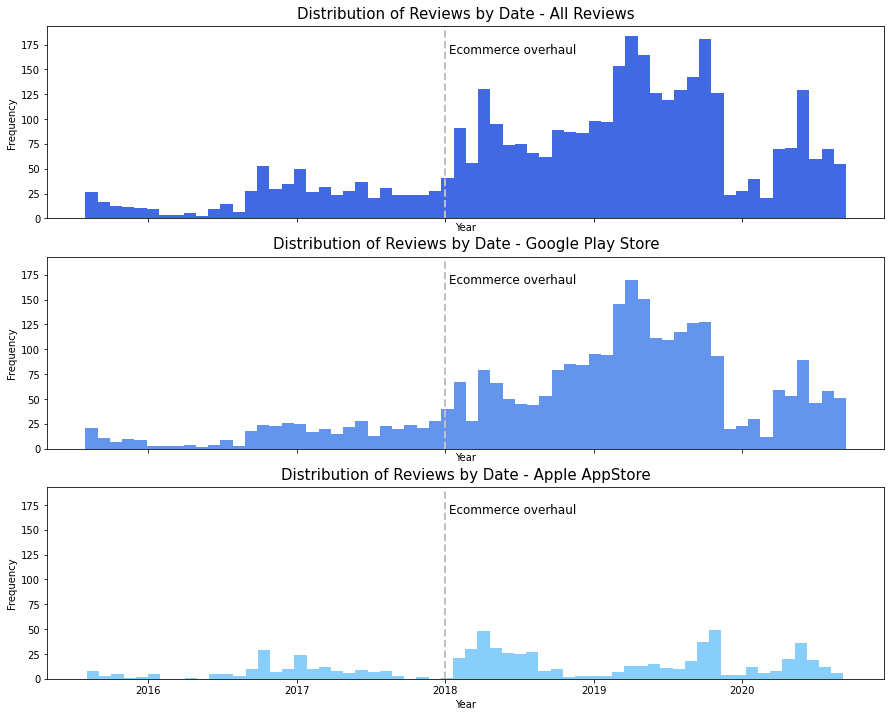

In [41]:
fig, ax = plt.subplots(nrows=3, figsize=(15,12), sharex=True, sharey=True)

data = [df['date'], df[df['source']=='googleplay']['date'], df[df['source']=='appstore']['date']]
titles = ['All Reviews', 'Google Play Store', 'Apple AppStore']
colors = ['royalblue', 'cornflowerblue', 'lightskyblue']

for i in range(3):
    ax[i].hist(data[i], bins=62, color=colors[i])   
    ax[i].set_title('Distribution of Reviews by Date - '+str(titles[i]), size=15, y=1.01)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Year')
    ax[i].axvline(x='2018-01-01', linestyle='dashed', linewidth=2, color='silver') 
    ax[i].text(x='2018-01-10',
               y=170,
               s='Ecommerce overhaul', 
               horizontalalignment='left', verticalalignment='center', fontsize=12);

Noting that the [NTUC Fairprice app was launched in August 2015](https://www.todayonline.com/shop-go-ntuc-fairprice), the combined dataset from Google Play Store and Apple AppStore contain reviews from 2015 to 2020.

Number of reviews began to rise in 2018, which is aligned to the timing of [NTUC Fairprice's e-commerce overhaul initiative](https://www.channelnewsasia.com/news/singapore/ntuc-fairprice-on-groceries-overhauls-online-shopping-platforms-10083152) and associated uptake in app usage.

## 2.2 Ratings

Let's take a look at the distribution of ratings.

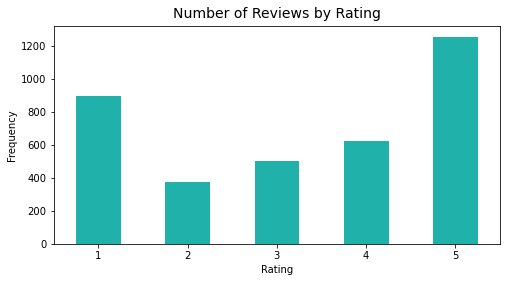

In [42]:
df['rating'].value_counts().sort_index().plot(kind='bar', color='lightseagreen', figsize=(8,4))
plt.title('Number of Reviews by Rating', fontsize=14, y=1.01)
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.xticks(rotation=0);

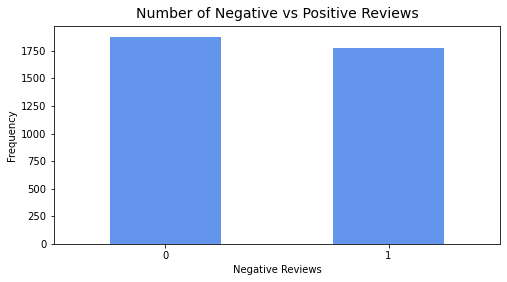

In [43]:
df['neg_review'].value_counts().plot(kind='bar', color='cornflowerblue', figsize=(8,4))
plt.title('Number of Negative vs Positive Reviews', fontsize=14, y=1.01)
plt.ylabel('Frequency')
plt.xlabel('Negative Reviews')
plt.xticks(rotation=0);

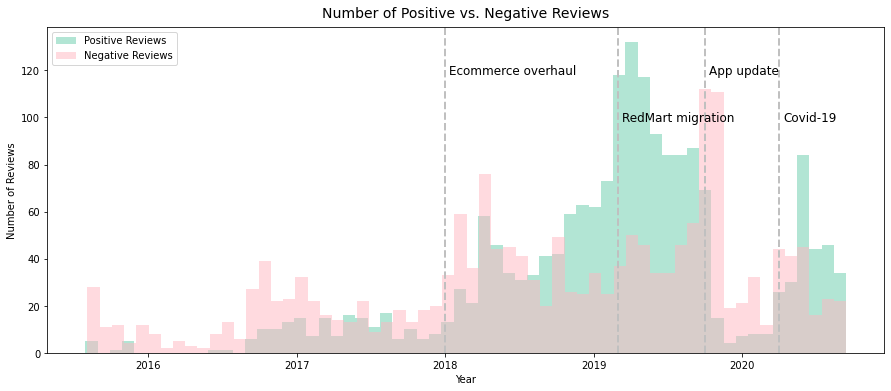

In [44]:
plt.figure(figsize = (15,6))
plt.hist(df[df['neg_review'] ==0]['date'], bins=62, color='mediumaquamarine', alpha=0.5,label='Positive Reviews')
plt.hist(df[df['neg_review'] ==1]['date'], bins=62, color='lightpink', alpha=0.5, label='Negative Reviews')
plt.title('Number of Positive vs. Negative Reviews', fontsize=14, y=1.01)
plt.ylabel('Number of Reviews')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.legend()
plt.axvline(x='2018-01-01', linestyle='dashed', linewidth=2, color='silver') 
plt.text(x='2018-01-10', y=120, s='Ecommerce overhaul', 
         horizontalalignment='left', verticalalignment='center', fontsize=12)
plt.axvline(x='2019-03-01', linestyle='dashed', linewidth=2, color='silver') 
plt.text(x='2019-03-10', y=100, s='RedMart migration', 
         horizontalalignment='left', verticalalignment='center', fontsize=12)
plt.axvline(x='2019-10-01', linestyle='dashed', linewidth=2, color='silver') 
plt.text(x='2019-10-10', y=120, s='App update', 
         horizontalalignment='left', verticalalignment='center', fontsize=12);
plt.axvline(x='2020-04-01', linestyle='dashed', linewidth=2, color='silver') 
plt.text(x='2020-04-10', y=100, s='Covid-19', 
         horizontalalignment='left', verticalalignment='center', fontsize=12);

Some interesting observations:

1. Spike in negative reviews immediately after NTUC's ecommerce overhaul in early 2018.
2. Peak in positive reviews for NTUC Fairprice app in early 2019, which is the time competitor [RedMart migration to Lazada's platform](https://theindependent.sg/more-customers-blast-redmart-lazada-merger-for-making-online-grocery-shopping-a-hassle/) after being acquired by Lazada.
3. Peak in negative reviews for NTUC Fairprice app around Oct 2019 during an app upgrade.
4. Surge in negative reviews in Apr 2020 at the start of Covid-19 circuit breaker in Singapore, followed by improvement in May 2020.

### 2.2.1 App Overhaul in Early 2018

Let's take a look at some of the negative reviews for the NTUC Fairprice app in early 2018.

In [45]:
pd.set_option('display.max_colwidth', None)
df[(df['neg_review'] == 1) & (df['year'] == 2018) & (df['month'] == 2)][['date','review', 'rating']].head(20)

,date,review,rating
403,2018-02-12 09:00:48,Your click and collect service sucks. First we ordered for collection on Saturday then it postponed to Sunday. We reach there to collect on Sunday morning then you asked to come back in the evening. We have our own appointment we can't compromise with your schedule. We came back again on Monday morning and you said you don't know where you placed our ordered. Such ridiculous service.,1
405,2018-02-09 15:28:02,"I am very annoying of ntuc online buying, always state that my card got problem, always got checking out problem. Very unfriendly and unefficiant.",1
406,2018-02-12 14:14:49,New upgrade version Unable to log in to my account. Keep asking to change password. Very Bad organiser all names are wrong.,1
407,2018-02-05 18:19:41,"Unable to check out the items, the system issues is pending for a week and hard to reach out to the customer service.",1
408,2018-02-28 14:55:49,Doesnt work. Keeps crashing.,1
409,2018-02-14 16:53:01,Locations not updated!,1
410,2018-02-01 15:16:11,Wasted half day trying to uninstall n install the app cos I cant add credit card details nor getting my checkout done!! Frustrated with the bad service fr the online customer service staff.,1
412,2018-02-03 15:45:52,"Difficult to navigate to the item i am looking for and i can't believe that so many items are out of stock, the photo and description for some of the items are not matching.",1
413,2018-02-04 17:26:14,"Sooo Less products , Even gave a wrong and irrelevant product when searched for 'bolster"" Gave me a god damn FISHCAKE. =.=",1
415,2018-02-04 10:38:44,"Keep prompting me password have to include alphanumeric, which i did. Can log in using my tablet but not my Note8.",1


In [46]:
df.loc[406, 'review']

'New upgrade version Unable to log in to my account. Keep asking to change password. Very Bad organiser all names are wrong.'

In [47]:
df.loc[740, 'review']

'The app needs a lot of improvement, especially to the sign in and shopping cart. App keeps logging off and I have to repeatedly add in the items time and again as the items inside the cart just vanished before check out. A long way to go for FairPrice before they can even come close to the apps of other online retailers'

In [48]:
df.loc[744, 'review']

'Slightly better than old version. But still not good experience. Very slow to load shopping cart. Shopping cart will be cleared after sometime, have to add to shopping list. The shortcut to check shopping cart is not always there.'

Teething problems such as logging in and shopping cart being cleared on its own were flagged out by users.

### 2.2.2 RedMart Migration to Lazada in Early 2019

Let's also check out the positive reviews in early 2019 when RedMart migrated to Lazada.

In [49]:
df[(df['neg_review'] == 0) & (df['year'] == 2019) & (df['month'] == 4)][['date','review', 'rating']]

,date,review,rating
1270,2019-04-17 12:33:35,"I've been using this app for a few months because it's very convenient. It's genrally user-friendly, great filter and search functions, good pictures and descriptions. However, it's slow to update the number of units, so I've received the wrong number of the same item a few times. On one occasion, I received the wrong fresh produce (presumably another customer's order). Tried customer service, but I didn't receive a reply.",4
1299,2019-04-08 12:49:12,User friendly app. Clear picture with excellent zoom in function. It would be better if date of expiry is also stated clearly.,4
1307,2019-04-27 13:18:26,app was so much faster to load and process as compared to online while accessing via mobile.,4
1319,2019-04-29 21:41:43,"Improved and I now prefer this to Redmart on Lazada. However could be better if we can update cart after placing orders, and also items saved to cart will not disappear after closing the app.",4
1321,2019-04-18 12:39:51,app is user friendly but the only setback is the replenishment items for fast sold out items seldom restock on time. Thx,4
...,...,...,...
2614,2019-04-02 16:27:38,good,5
2942,2019-04-06 06:43:24,"Satisfied The app has improved so much since the last time I used. I can find close to all the items I need. Sometimes even those that I don’t see in every store. The app is updated with weekly PWPs and offers which are found in the stores as well. It is so convenient for me, esp with 2 young kids. I do not need to queue to make payment and carry those heavy and big items home now. Delivery timings can also be selected to make sure you are around when your loot arrives. This is very important if you order frozen and chilled items. Overall, highly satisfied.",5
3272,2019-04-19 07:26:19,Words too small on ipad But thank you for the app.,4
3316,2019-04-21 00:20:25,Convenient App Easy to navigate.,4


Diving in to the reviews that explicitly compare with Redmart:

In [50]:
df[(df['neg_review'] == 0) & (df['year'] == 2019) & (df['month'] == 4) & (df['review'].str.contains('Redmart'))][['date','review', 'rating']]

,date,review,rating
1319,2019-04-29 21:41:43,"Improved and I now prefer this to Redmart on Lazada. However could be better if we can update cart after placing orders, and also items saved to cart will not disappear after closing the app.",4


In [51]:
df[(df['neg_review'] == 0) & (df['year'] == 2019) & (df['month'] == 4) & (df['review'].str.contains('redmart'))][['date','review', 'rating']]

,date,review,rating
1448,2019-04-23 10:28:52,Could be more user friendly but at least its not as terrible as redmart on lazada. Customer service was quick to resolve missing and spoilt items issue.,4
2087,2019-04-06 22:27:02,switched from redmart cos I hated how complicated it got to place order or get customer support. this is much better! thanks!,5


RedMart's migration to Lazada did not sit well with customers, leading to more positive sentiment for NTUC Fairprice app in early 2019.

### 2.2.3 App Update in Late 2019

In [52]:
df[(df['neg_review'] == 1) & (df['year'] == 2019) & (df['month'] == 10)][['date','review', 'rating']]

,date,review,rating
38,2019-10-03 21:53:14,"The upgrade slows down everything. Why ask for delivery address first? I prefer the older app which asks for address after order is confirmed and paid. Special offers highlighted in red shows only 1 line of text, which means I have to click on it to read what the special offer is. Slows things down. Imagine having to click on the red text for all the items you're ordering. The search engine is also not smart and intuitive. I don't feel like ordering.",1
41,2019-10-20 14:40:56,"The transaction could not go through citing to me that my ocbc credit card had expired. I uninstalled and reinstalled the app, deleted and added the credit card details only to be told the same error message. I tried a credit card with another bank, dbs, and it worked. I even called ocbc to verify the status of the card abd the cso reassured me that there was no issue. A huge inconveniece indeed!",1
44,2019-10-20 10:57:18,"The old apps used to work fine. After some upgrade, it was horrible. The payment and checkout keep registering unsuccessful transaction and ask to check for card expiry. It is your apps problem NTUC FairOn ...nothing to do with the bank credit card. When the app is doing fine, leave it - don't be too clever to change it. BTW, the new app is not user friendly because you cannot re-order again from your last order...disappointing!",1
49,2019-10-22 18:08:02,"After app update, browsing become laggy, especially when +/- qty in the cart. And why remove the barcode scanner??? It was so easy to find item online when i could scan the barcode on the item. The search online is not align with items at all!.. I key in dory steak and pork will appear..",1
52,2019-10-30 12:09:48,"Three previous orders went thru without any issue. However, for the last order made last week, the order status is not updated at all till now while I am writing this review. Twice reinstall of apps(told to) which doesn't resolve issue. Called in vain a few times, to check on the delivery, it finally arrived at the very last minute of the 2-hrs time slot, came at 5:59pm. No link points given on all purchases too. No response received yet as of today 30 Oct 2019.",1
...,...,...,...
3420,2019-10-07 05:29:29,Cannot open the app Kept reverting me back to update the app,1
3426,2019-10-06 19:27:30,New upgrade keeps CRASHING!!! Please test before release!,1
3628,2019-10-28 06:16:52,"The new app does not work as it claimed Been a regular user of NTUC in the past with no issues. But with the current updated app, it makes the whole experience worse. \n1) Mentioned Free delivery after adding in items (which supposed to be of S$39.90). While check out, delivery fees of S$ 7 was added in.\n2) App works slower from searching items or reflecting from one point to another.\n3) After spending long time and finally time for check out, ‘opps something went wrong 400 status’. Tried 4 more times and still the same message shows. Like seriously ~ what is the error ? No , it did mention. With existing singed up account, how come this whole online shopping can be so miserable ?",1
3629,2019-10-20 02:23:47,"Cannot rely on this software 1. Lets you create the order but cannot checkout. Error “Oops, something went wrong”\n2. If you use this software on a computer then it is damn slow. You will loose patience as it is not optimised for better user experience.\n\nI feel both developers and sponsors are not taking the competition into their account. Please ask them to use other online shopping tools (recent entries in Singapore markets) to know what could be better stability and user experience.",1


In Oct 2019, an update in the NTUC Fairprice app caused a series of problem, e.g. the app crashing or laggy, users unable to complete transaction. This again points to the importance of testing before launching any update.

### 2.2.4 Covid-19

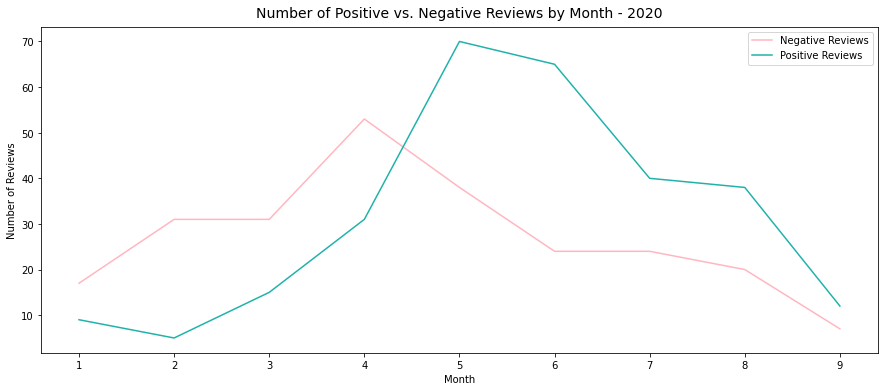

In [53]:
plt.figure(figsize=(15,6))
df[(df['year'] == 2020) & (df['neg_review'] ==1)]['month'].value_counts().sort_index().plot(color='lightpink', label='Negative Reviews')
df[(df['year'] == 2020) & (df['neg_review'] ==0)]['month'].value_counts().sort_index().plot(color='lightseagreen', label='Positive Reviews')
plt.title('Number of Positive vs. Negative Reviews by Month - 2020', fontsize=14, y=1.01)
plt.ylabel('Number of Reviews')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.legend();

Focusing on 2020, the number of negative reviews peaked in April, coinciding with the begining of the circuit breaker period. Following that, more positive reviews were seen in May and Jun 2020.

In [54]:
df[(df['neg_review'] == 1) & (df['year'] == 2020) & (df['month'] == 4)][['date','review', 'rating']]

,date,review,rating
17,2020-04-12 00:20:56,The app is very very slow and takes a very long time to load. Alot of the items are out of stock too. The delivery time is also unavailable. I have been trying to load my cart for more than half an hour now and it's still not loading until now. ( not my network as all the other apps works perfectly fine),1
18,2020-04-15 22:42:22,"At first, delivered items on the last order still appeared in the cart. After removing them manually item by item, they still appeared after opened app from another phone. Then all reappeared on my phone after I clicked on cart. fter I spent 30 mins putting itens into cart, all items disappeared! It seems items which should be removed aren't removed and items which are newly added are removed. Wasted my time and effort!!!",1
21,2020-04-18 09:23:27,"This app is good, but I want buy something but in this app show the item is out of stock. I go nearest Fair Prices see the items I need got stocks, why this happens? Why this app didn't update the listing? Always dont have times slots",1
22,2020-04-05 00:27:03,"App checkout was so slow. When I was trying to pay my bank gave an error with an OTP which turn made my transaction unsuccessful. And to make matters worse, my cart became empty.",1
23,2020-04-20 19:54:39,Please let us choose the date and time slot for next week or further date. And do not update the cart until we click checkout..or else every time we have to re add in the items repeatedly.,1
25,2020-04-06 00:17:20,"I don't know how this app was on normal times, but in this high demand time, exactly at midnight the cart never loads, and after every few minutes it says my cart is empty. Failed Load Test Miserably",1
26,2020-04-12 11:45:06,"Have been waiting for the earliest timeslot. It appeared. But then as i wanted to place order, it disappeared again. Please have it fixed. Thanks.",1
27,2020-04-21 15:41:00,"this app is as good as useless when everyday the delivery slots are full and the items in the cart is getting out of stock, item by item.",1
28,2020-04-12 11:30:43,could not check out. reset my cart to empty twice! server very laggy.,1
29,2020-04-12 20:34:36,"Have been monitoring the delivery slots for many days. Whenever there's slot, i get error messages and order can't put through! How to stay at home? Forcing people to go on street... goodness me...",1


At the start of Covid-19 Circuit Breaker in Apr 2020, many users gave negative reviews mainly for the app being laggy, out-of-stock and no delivery slot situation.

In [55]:
df[(df['neg_review'] == 0) & (df['year'] == 2020) & (df['month'] == 5)][['date','review', 'rating']]

,date,review,rating
1257,2020-05-26 09:48:49,"Well, found that the page got improve. More delivery slot found. Keep up the good work. Thanks.",4
1258,2020-05-11 22:47:45,User Friendly and easy to navigate. But delivery slot is always full.,4
1259,2020-05-26 14:28:09,"Great shopping experience, much easier to get delivery slots now. Will be better if offer more complete range of products online, as well as more stocks, as popular stuff always out of stock too",4
1260,2020-05-30 11:00:30,"In beginning of cb period is very hard to get delivery slot. And your orders is always being modified on the day of delivery due to out of stock. If buy for stock up, it is good apps. If buy for urgent use, pls forget this apps.",4
1261,2020-05-25 12:22:54,"Similar to shopping on site, previously its hard to get delivery slot, now looks like better",4
...,...,...,...
3159,2020-05-16 16:15:18,Some items out of stock for weeks Some items out of stock for weeks,4
3276,2020-05-09 00:23:12,Delivery slot Difficult to get a delivery slot but today is the lucky day,4
3301,2020-05-22 08:24:19,Awesome experience Great experience to the new way of life.,5
3328,2020-05-19 02:15:08,"Packing need to be improve, thanks Packing need to be improve, thanks",4


In [56]:
df.loc[1261, 'review']

'Similar to shopping on site, previously its hard to get delivery slot, now looks like better'

In [57]:
df.loc[3301, 'review']

'Awesome experience Great experience to the new way of life.'

In May 2020, the app obtained more positive reviews as there seems to be improvement to out of stock and no delivery slot issues as compared to Apr 2020, and consumers are embracing the 'new normal'.

### 2.2.5 Current Situation in Sep 2020

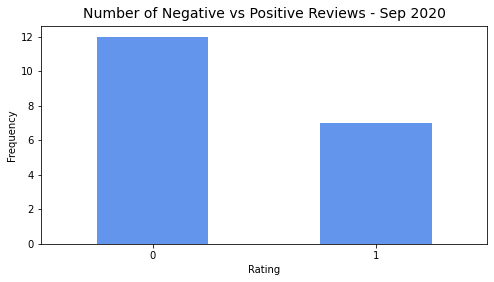

In [58]:
df[(df['year'] == 2020) & (df['month'] ==9)]['neg_review'].value_counts().plot(kind='bar', color='cornflowerblue', figsize=(8,4))
plt.title('Number of Negative vs Positive Reviews - Sep 2020', fontsize=14, y=1.01)
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.xticks(rotation=0);

For the month of Sep 2020, positive reviews (class 0) outweighs negative reviews.

In [59]:
df[(df['neg_review'] == 1) & (df['year'] == 2020) & (df['month'] == 9)][['date','review', 'rating']]

,date,review,rating
0,2020-09-11 13:47:35,Not a good experience for first timer. Login and sign up was not a problem. What i did not like at all was after entering all details it prompted me no delivery dates are available which should have been the first step instead of last,1
2,2020-09-06 08:10:27,Lousy app. Cannot find most items using brand name. Now they change the use of label scanning in app which totally disable the label function when store not detected. Slow and unstable. Any online grocery app now is far better.,1
14,2020-09-06 03:05:53,Purchases made through your FairPrice app will not get to earn Link! Points. Very unfair and highly disappointed at your policies. Will delete this app henceforth.,1
24,2020-09-08 13:59:43,"I have shifted to Red mart and PrimeNow for some time due to bad experience. Thought to give it a try again, but experience is still bad. Always no stock on very basic items and limited selections that is far far less than the physical store. Eg. fresh seafood, pork...even don't have regular tomatoes. Worst, the order is almost always amended to remove a few items due to no stock. This creates problem as the main ingredient for a dish is gone.The inventory system is certainly broken.",1
330,2020-09-05 11:11:17,"Under the HELP category, photo is not attachable & thus feedback cannot be submitted making the whole process inconvenient & troublesome. Please resolve this.",1
3179,2020-09-05 01:38:49,"OOS ? App unable to sign in? I Just made my first purchased, the next thing is no replacement or called up on out of stock order. And can’t sign in my account after my purchase. This is Disappointment as I rarely spend on shopping online.",1
3270,2020-09-05 03:08:08,App have issue I encounter issue making payment using the app.\nNot able to key in OTP. Pls assist to look into it,3


Among the 7 negative reviews collected, almost half were related to out-of-stock or no delivery slot issue. These are issues that NTUC Fairprice has to continue to look into.

# 3. VADER Sentiment Analysis

[VADER](https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f) (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text. The VADER Sentiment Intensity Analyzer generates four scores:
* Negative score
* Neutral score
* Positive score
* Compound score (computed by normalizing the scores above)

These scores can potentially be additional features to help classify Positive and Negative Reviews.

Since VADER uses non-words (e.g. emoji) as well, I will apply it to the reviews to get its sentiment scores before preprocessing on the text.

In [60]:
analyzer = SentimentIntensityAnalyzer()

In [61]:
df['compound_score'] = [analyzer.polarity_scores(post)['compound'] for post in df['review']]
df['neg_score'] = [analyzer.polarity_scores(post)['neg'] for post in df['review']]
df['neu_score'] = [analyzer.polarity_scores(post)['neu'] for post in df['review']]
df['pos_score'] = [analyzer.polarity_scores(post)['pos'] for post in df['review']]

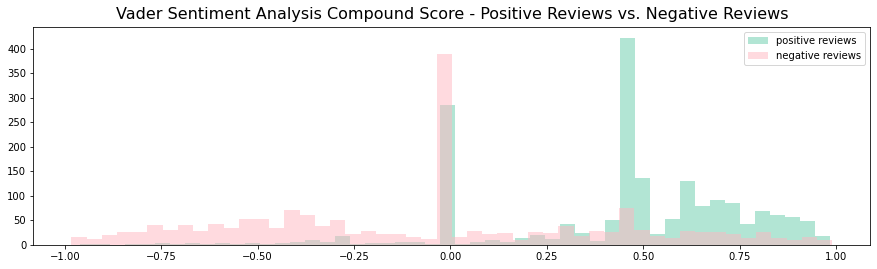

In [62]:
plt.figure(figsize = (15,4))
plt.hist(df[df['neg_review'] == 0]['compound_score'], bins=50, color='mediumaquamarine', alpha=0.5, label='positive reviews')
plt.hist(df[df['neg_review'] == 1]['compound_score'], bins=50, color='lightpink', alpha=0.5, label='negative reviews')
plt.legend()
plt.title('Vader Sentiment Analysis Compound Score - Positive Reviews vs. Negative Reviews', fontsize=16, y=1.01);

Based on the compound score from VADER, it appears that there is bunching around compound score of around 0.0 for both positive and negative reviews, which means that compound score may not be a good feature to predict positive vs. negative reviews.

Let's filter for negative reviews with high compound score to figure out why the discrepancy.

In [63]:
df[(df['neg_review'] == 1) & (df['compound_score'] >0.8)][['review', 'rating', 'neg_review', 'compound_score', 'neg_score', 'neu_score', 'pos_score']].sort_values('compound_score', ascending=False).head(10)

,review,rating,neg_review,compound_score,neg_score,neu_score,pos_score
3454,"Has improved but more room for improvement The app has improved significantly since I first used it years ago. However, there is still room for improvement, esp in product search functions and sorting. FairPrice is also not open & transparent with their promo codes. Often I have to surf 3rd party websites for their promo codes. The added ability to save cart contents now is definitely a welcomed improvement to their first version app which refreshes after ~20min, erasing cart contents. At least u can logout and login again another time to continue your shopping. Keep up the improvements 👍🏻",3,1,0.9906,0.000,0.705,0.295
711,1. No link points collection as there are online sales 2. Always asking me \nto update to latest version but still bring me back to the old version 3. \nEasy to pick items I want to purchase and no need to carry heavy items 4. \n$59 for free delivery is quite ok 5. Easy to reach customer service hotline \nwhich can be found in the app. 6. Still can't figure it out how to save my \nother credit cards details as this app state I can save up to 3 credit \ncards?? 7. I just went to samsung to check why my phone is so hot! \nApparently the worst app that is draining a lot of the very and usage of \nthe phone is this app! Omg,2,1,0.9768,0.063,0.718,0.219
1127,user friendly as can order on the go but can be better if screen can load more products to view at a glance. best if intelligent s/w can help propose related products to make online shopping easier.,3,1,0.9750,0.000,0.574,0.426
3446,"Legit complaints from a frequent shopper I really hope NTUC succeeds in its foray into the digital space so hear me out here. \n\n1. Bad UX\n\n- i can search when I’m not signed in, and when I want to add to my cart I have to sign in which is fair. But when I do, the stuff that I saw that was available is suddenly unavailable. For example, Pampers Premium Care.\n\n- search results are not sorted according to type or relevance! Which is the bare minimum of an e-commerce app. For example, when I search for rice noodles, the first five results are rice noodles or noodles then a trickle of irrelevant products then rice noodles appearing then irrelevant products then rice noodles etc. Why??\n\n- some search results are not relevant! when I search for “rice noodles” I am shown tomato paste, olive oil, canola oil, virgin coconut oil, mustard dressing etc. Why???\n\n- after search results are displayed I have to scroll upwards manually to view starting from top to bottom. Why doesn’t it display from the top results?\n\n- can you please place all the unavailable items towards the bottom of the search results instead of weaving them intermittently within the available items?\n\n2. Bad fulfilment\n\nThe delivery service is really superb. On time, and within the same day of ordering even. However, I refrain from ordering fresh items like chicken or vegetables after a couple times bad experience where I was allocated stale chicken and very old vegetables. To be fair, Sheng Siong and RedMart both do poorly on this category. So should NTUC treat this gap as a major opportunity to outshine your competitors?\n\n3. Bad inventory management\n\nAbout 50% of the time, my confirmed orders are updated to exclude a couple of items that are not available.\n\n100% of the time, many items that I want to buy aren’t available. I’m hard pressed to fill my cart of items worth $79 because so many items are unavailable!",1,1,0.9734,0.058,0.817,0.125
597,"Dev should look at other shopping apps. There are so much this NTUC shopping app can improve on. /-- suggestion --/ #1. To remember last Click n Collect location and option to choose timing to coincide when I would be there after work. #2. Option to add to wish list on all pages #3. Wish lists should NEVER be limited to just 5!!! Put on your Sales & Marketing thinking hat on! #3. Make wish lists more user friendly (see Amazon, to set de

It can be seen that for very long reviews, for which the 'neutral score' tend to be high, leading to a high compound score. The positive scores are these reviews are in fact not that high.

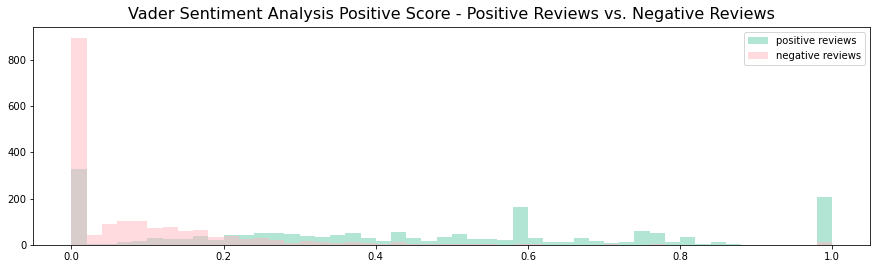

In [64]:
plt.figure(figsize = (15,4))
plt.hist(df[df['neg_review'] == 0]['pos_score'], bins=50, color='mediumaquamarine', alpha=0.5, label='positive reviews')
plt.hist(df[df['neg_review'] == 1]['pos_score'], bins=50, color='lightpink', alpha=0.5, label='negative reviews')
plt.legend()
plt.title('Vader Sentiment Analysis Positive Score - Positive Reviews vs. Negative Reviews', fontsize=16, y=1.01);

The positive score appears to be better indicator of positive vs. negative reviews.

# 4. Text Preprocessing & Further Exploratory Data Analysis

## 4.1 Text Preprocessing

Let's prepare the review data for text classfication. I will:

* Remove HTML tags using BeautifulSoup
* Remove non-letter characters
* Convert words to lower case
* Remove stop words
* Lemmatize the words to its root word form using NLTK Lemmatizer

In [65]:
def text_processing(raw_text):
  
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Searching through a set is faster than searching through a list 
    # Hence, we will convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # Adding on stopwords related to topic to avoid target leakage
    stops.update(['app', 'apps', 'application', 'ntuc','fairprice']) 
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
    
    # Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatized words
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]   
   
    # Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [66]:
df['review_lem'] = df['review'].map(text_processing)

Let'e compare a review before and after preprocessing.

In [67]:
# review BEFORE preprocessing
df['review'][0]

'Not a good experience for first timer. Login and sign up was not a problem. What i did not like at all was after entering all details it prompted me no delivery dates are available which should have been the first step instead of last'

In [68]:
# review AFTER preprocessing
df['review_lem'][0]

'good experience first timer login sign problem like entering detail prompted delivery date available first step instead last'

## 4.2 Checking for Reviews with No Meaningful Words

After preprocessing, there may be reviews with no meaningful words. Let's check for them and remove them before modelling.

In [69]:
df['review_lem_length'] = df['review_lem'].str.split().map(len)

In [70]:
df[df['review_lem_length'] == 0].shape

(22, 14)

In [71]:
df[df['review_lem_length'] == 0][['review', 'rating', 'source']]

,review,rating,source
509,:&lt;,1,googleplay
578,With,1,googleplay
1573,😉,4,googleplay
2431,👍👍👍,5,googleplay
2436,😍😍😍😋😋😊😊😁😁,5,googleplay
2438,👍,5,googleplay
2474,👍👍,5,googleplay
2475,👍,5,googleplay
2508,👍👍👍,5,googleplay
2522,👍,5,googleplay


There are 22 reviews with no meaningful words. Most of them contain emoji only. Let's proceed to drop these reviews.

In [72]:
# drop reviews with no meaningful word
df = df.drop(df[df['review_lem_length'] == 0].index)

In [73]:
df.reset_index(drop=True, inplace=True)

In [74]:
df.shape

(3635, 14)

After dropping reviews with no meaningful words after text preprocessing, there are 3635 reviews in the dataset.

## 4.3 Number of Meaningful Words

Let's take a look at the length of review after preprocessing.

In [75]:
positive_length = df[df['neg_review'] == 0]['review_lem_length'].mean()
negative_length = df[df['neg_review'] == 1]['review_lem_length'].mean()

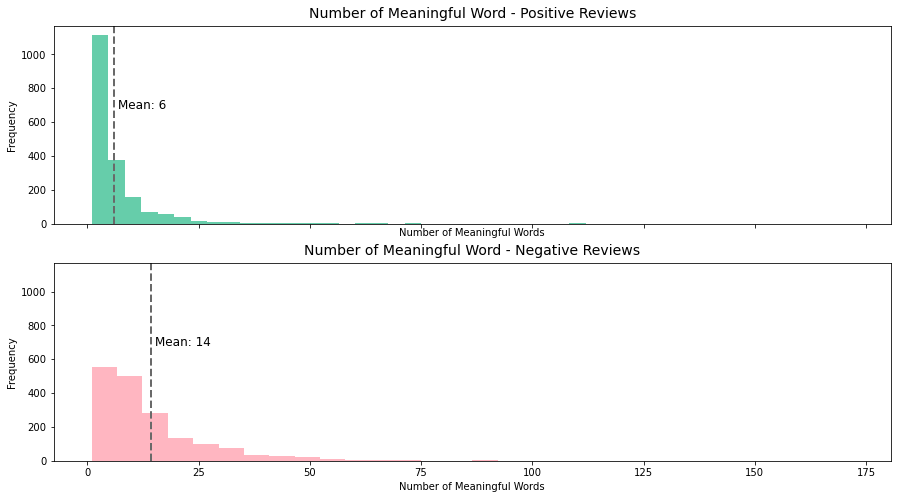

In [76]:
fig, ax = plt.subplots(nrows=2, figsize=(15,8), sharex=True, sharey=True)

titles = ['Positive Reviews', 'Negative Reviews']
colors = ['mediumaquamarine', 'lightpink']
lengths = [positive_length, negative_length]

for i in range(2):
    ax[i].hist(df[df['neg_review'] == i]['review_lem_length'], bins=30, color=colors[i])
    ax[i].set_title('Number of Meaningful Word - '+str(titles[i]), size=14, y=1.01)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Number of Meaningful Words');
    ax[i].axvline(df[df['neg_review'] == i]['review_lem_length'].mean(), 
                  linestyle='dashed', linewidth=2, color='dimgray') 
    ax[i].text(x=lengths[i]+1,
               y=700,
               s=f'Mean: {round(lengths[i])}', 
               horizontalalignment='left', verticalalignment='center', fontsize=12);

Overall, the length of negative reviews tend to be longer (mean length of 14 meaningful words), while positive reviews are shorter (with mean length of 6 meaningful words).

## 4.4 Most Frequently Occurring Words for Positive and Negative Reviews

### 4.4.1 Word Clouds

I will first use word clouds as a quick visualisation of frequently occurring words in the negative and positive reviews.

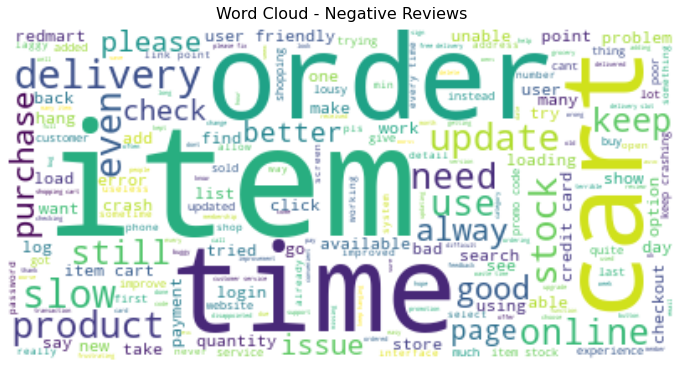

In [77]:
# word cloud for negative reviews
negative_reviews = df[df['neg_review'] == 1]['review_lem']
wordcloud_negative = WordCloud(background_color="white").generate(' '.join(negative_reviews))

plt.figure(figsize = (12,10))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews', fontsize=16, y=1.01)
plt.axis("off");

As for the word cloud for **negative reviews**, frequently occurring words include **item, time, card, order and delivery**. 

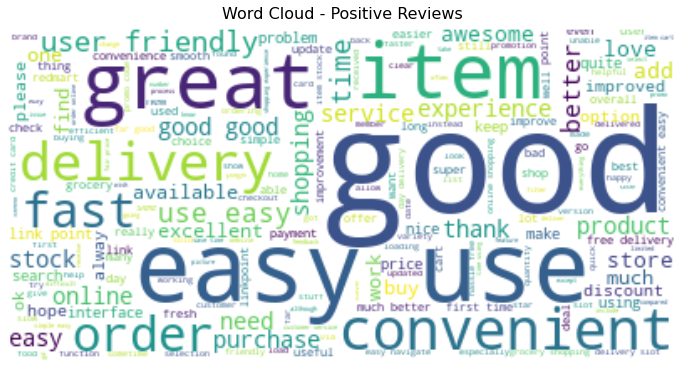

In [78]:
# word cloud for positive reviews
positive_reviews = df[df['neg_review'] == 0]['review_lem']
wordcloud_positive = WordCloud(background_color="white").generate(' '.join(positive_reviews))

plt.figure(figsize = (12,10))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews', fontsize=16, y=1.01)
plt.axis("off");

Based on the word cloud for **positive reviews**, **easy, use, good, great** are frequently used words.

### 4.4.2 Top Uni-grams and Bi-grams

In [79]:
df_positive = df[df['neg_review'] == 0]
df_negative = df[df['neg_review'] == 1]

In [80]:
# instantiate countvectorizer for uni-grams
cvec_positive_unigrams = CountVectorizer()
# fit countvectorizer with positive reviews
positive_unigrams = cvec_positive_unigrams.fit_transform(df_positive['review_lem'])

# get the most frequently occuring uni-grams for positive reviews
positive_unigrams_df = pd.DataFrame(positive_unigrams.toarray(), columns = cvec_positive_unigrams.get_feature_names())
top_positive_unigrams = positive_unigrams_df.sum().sort_values().tail(20)

In [81]:
# instantiate countvectorizer for bi-grams
cvec_positive_bigrams = CountVectorizer(ngram_range=(2,2))
# fit countvectorizer with positive reviews
positive_bigrams = cvec_positive_bigrams.fit_transform(df_positive['review_lem'])

# get the most frequently occuring bi-grams for positive reviews
positive_bigrams_df = pd.DataFrame(positive_bigrams.toarray(), columns = cvec_positive_bigrams.get_feature_names())
top_positive_bigrams = positive_bigrams_df.sum().sort_values().tail(20)

In [82]:
# instantiate countvectorizer for uni-grams
cvec_neg_unigrams = CountVectorizer()
# fit countvectorizer with negative reviews
neg_unigrams = cvec_neg_unigrams.fit_transform(df_negative['review_lem'])

# get the most frequently occuring uni-grams for negative reviews
neg_unigrams_df = pd.DataFrame(neg_unigrams.toarray(), columns = cvec_neg_unigrams.get_feature_names())
top_neg_unigrams = neg_unigrams_df.sum().sort_values().tail(20)

In [83]:
# instantiate countvectorizer for bi-grams
cvec_neg_bigrams = CountVectorizer(ngram_range=(2,2))
# fit countvectorizer with negative reviews
neg_bigrams = cvec_neg_bigrams.fit_transform(df_negative['review_lem'])

# get the most frequently occuring bi-grams for negative reviews
neg_bigrams_df = pd.DataFrame(neg_bigrams.toarray(), columns = cvec_neg_bigrams.get_feature_names())
top_neg_bigrams = neg_bigrams_df.sum().sort_values().tail(20)

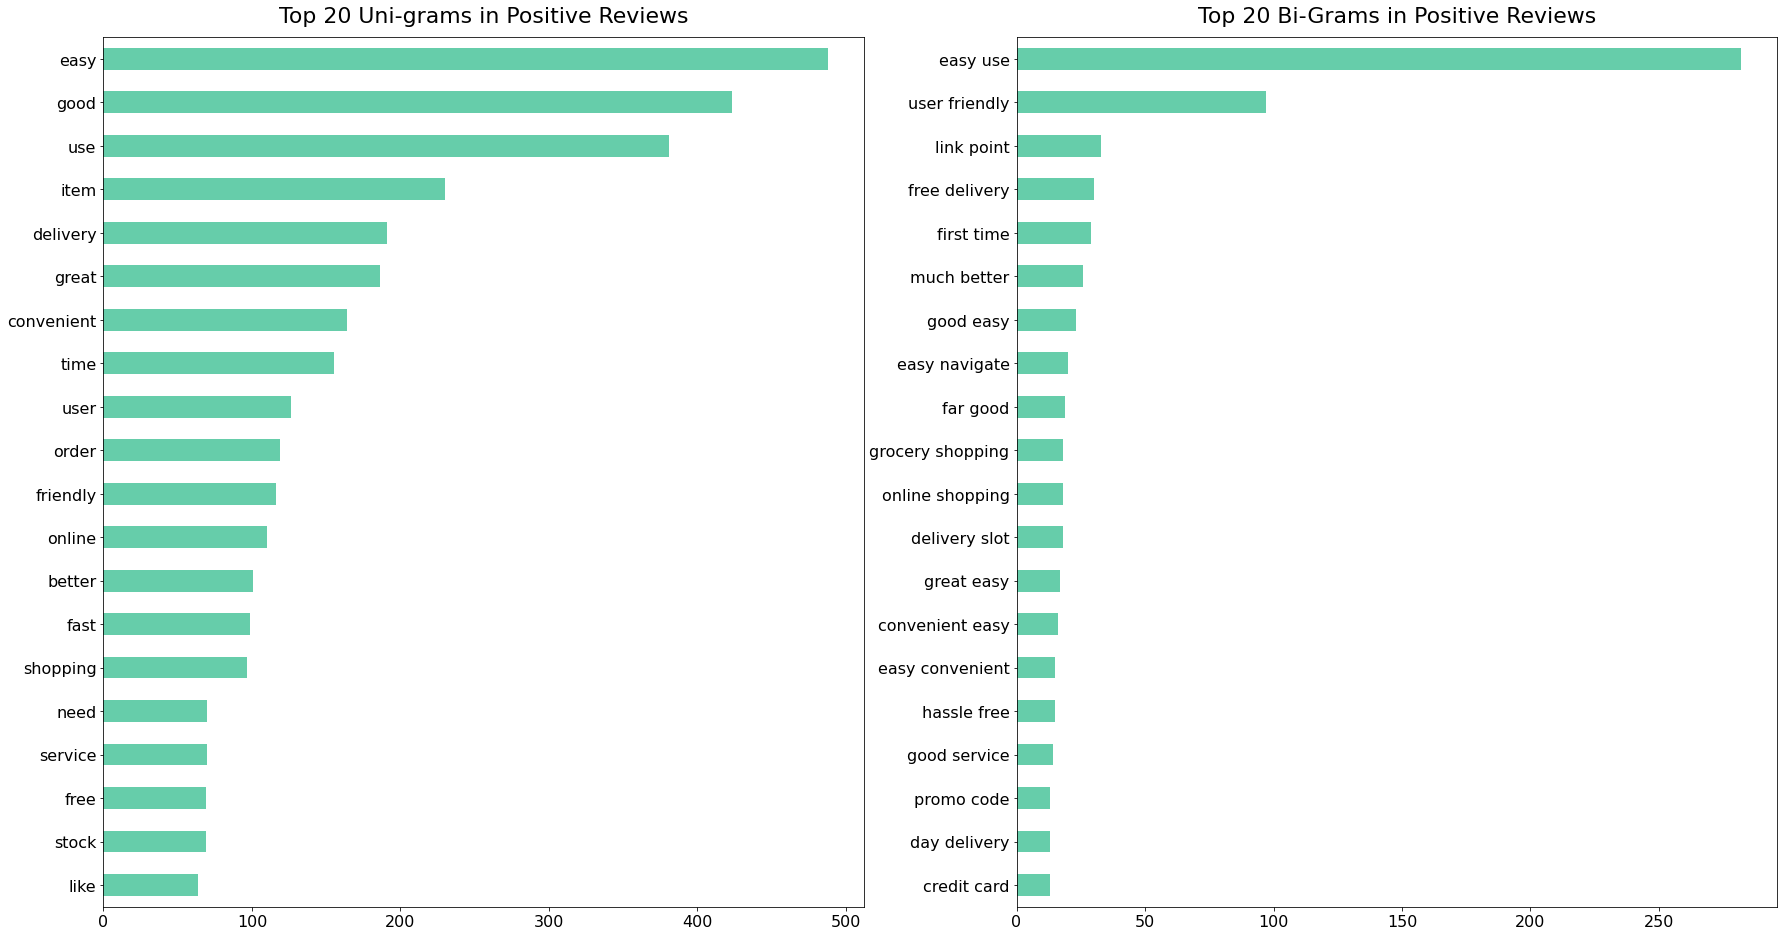

In [84]:
# plot most frequently occurring uni-grams and bi-grams for positive reviews
fig, ax = plt.subplots(ncols=2, figsize=(30,16))

positive_words = [top_positive_unigrams, top_positive_bigrams]
titles = ['Uni-grams', 'Bi-Grams']

for i in range(2):
    positive_words[i].plot(ax=ax[i], kind='barh', legend=None, color='mediumaquamarine')
    ax[i].set_title('Top 20 '+titles[i]+' in Positive Reviews', fontsize=22, y=1.01)
    ax[i].tick_params(axis='both', which='major', labelsize=16)

Analysing the top uni-grams and bi-grams for the **positive reviews**:

* **Easy**, **easy use** and **user friendly** emerge as the top most frequently mentioned words, indicating at ease of use is important.

* **Link point**, which is NTUC's loyalty programme, is also among the top bi-grams, indicating the importance of such incentives to retain customers.

In [85]:
# examples of positive reviews with the unigram 'easy'
df[(df['neg_review'] == 0) & (df['review_lem'].str.contains('easy'))][['date','review', 'rating']].head()

,date,review,rating
1242,2020-07-07 06:52:09,easy to use but i just found out that they will offer the items but to the total bill they charged as normal so its useless the offer. So if you dont check it 1 by one you woudnt know! Its called cheating to the consumers! Today invoice i realized that but when i checked my previous delivery all same! Its waa so unfair!,4
1244,2020-08-19 22:58:24,Easy to serve around. Only thing is the packing service fee is expensive.,4
1246,2020-08-23 02:01:43,Easy and pleasant way to shop online.,4
1250,2020-06-14 11:47:36,Easy to use. Would be best if can show how much link points has been earned from purchase. There is improvement on the variety of products.,4
1251,2020-04-16 15:08:10,"Easy to use, just that must keep checking every hour to see when the delivery slots avail. I have a suggestion! Please tag pet food with a PET FOOD tag in the picture. I search for 'Tuna' and more than half are cat food. Its okay if all the cat food had cat and dog image, but there was a japanese brand that did NOT have animal image in the picture and looked like atas tuna w scallop. Luckily I can read the very long item description about heavenly food for cats but Ah Ma/Auntie maybe cannot!",4


In [86]:
# examples of positive reviews with the biigram 'easy use'
df[(df['neg_review'] == 0) & (df['review_lem'].str.contains('easy use'))][['date','review', 'rating']].head()

,date,review,rating
1242,2020-07-07 06:52:09,easy to use but i just found out that they will offer the items but to the total bill they charged as normal so its useless the offer. So if you dont check it 1 by one you woudnt know! Its called cheating to the consumers! Today invoice i realized that but when i checked my previous delivery all same! Its waa so unfair!,4
1250,2020-06-14 11:47:36,Easy to use. Would be best if can show how much link points has been earned from purchase. There is improvement on the variety of products.,4
1251,2020-04-16 15:08:10,"Easy to use, just that must keep checking every hour to see when the delivery slots avail. I have a suggestion! Please tag pet food with a PET FOOD tag in the picture. I search for 'Tuna' and more than half are cat food. Its okay if all the cat food had cat and dog image, but there was a japanese brand that did NOT have animal image in the picture and looked like atas tuna w scallop. Luckily I can read the very long item description about heavenly food for cats but Ah Ma/Auntie maybe cannot!",4
1272,2019-09-27 08:52:53,"Very easy to use, have super wide range of products just like what they have in the physical super market, and I get to enjoy discounts from shopping through the app too. However, I need to login everytime I open the app, which is a tiny bit troublesome.",4
1285,2019-01-22 23:22:58,Very convenient & easy to use. However not all items available! Also no link points tie-up.,4


The positive reviews with the bi-gram 'easy use' are basically those talking about how the app is easy to use.

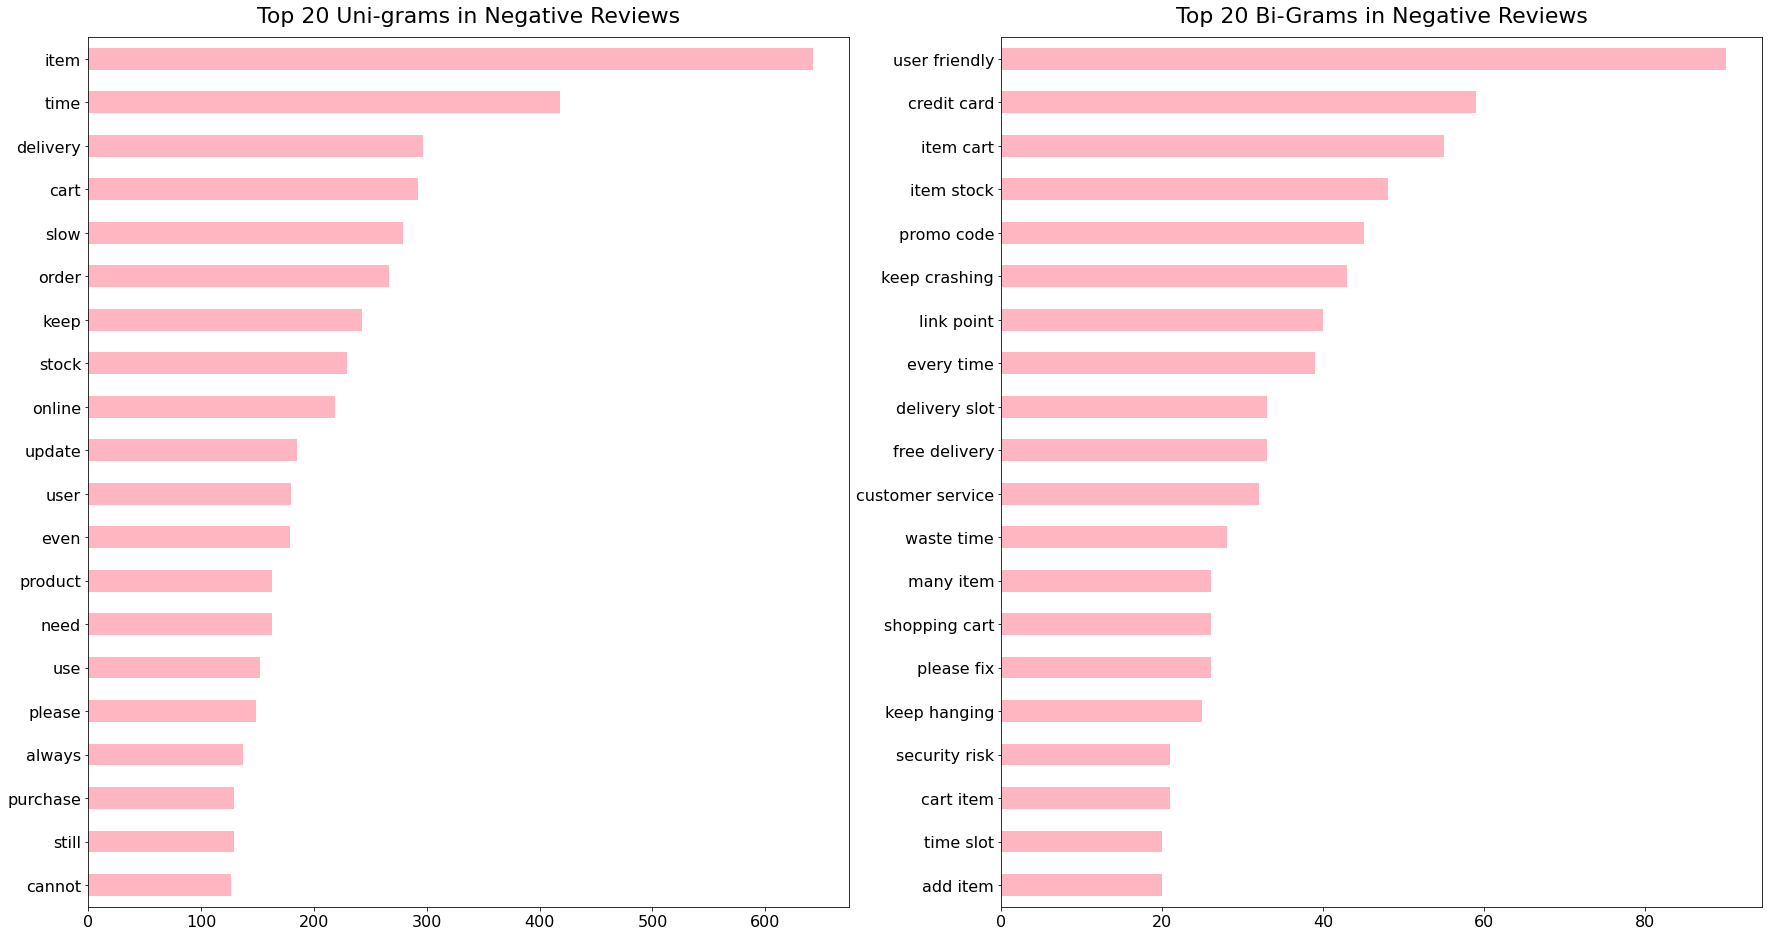

In [87]:
# plot most frequently occurring uni-grams and bi-grams for negative reviews
fig, ax = plt.subplots(ncols=2, figsize=(30,16))

negative_words = [top_neg_unigrams, top_neg_bigrams]
titles = ['Uni-grams', 'Bi-Grams']

for i in range(2):
    negative_words[i].plot(ax=ax[i], kind='barh', legend=None, color='lightpink')
    ax[i].set_title('Top 20 '+titles[i]+' in Negative Reviews', fontsize=22, y=1.01)
    ax[i].tick_params(axis='both', which='major', labelsize=16)

As for the **negative reviews**:

* Again, **user friendly** (or the lack of it) is the most frequently occurring bi-gram
* Other most frequently occurring words include **item**, **time**, **delivery**, **cart**, **credit card**, **item cart**, **item stock** seem to point to issues with item availability, delivery, check-out and payment experience.

In [88]:
# examples of negative reviews with the unigram 'item'
df[(df['neg_review'] == 1) & (df['review_lem'].str.contains('item'))][['date','review', 'rating']].head()

,date,review,rating
1,2020-07-31 21:04:24,"One of the lousiest app! Tried using it several times since May 20 but never once did I complete the transaction. Reason: 1. In May 20 it always say ""no slot"". By the time there was slot, many items in my cart had become ""no stock"". No point for me to pay the delivery fee for a ""half-filled cart"". 2. In Jul 20 I tried to use the app again to utilise a promo code. But it kept saying ""promo code error"". When the code finally got accepted, some items became ""no stock"" again. It's so irritating!",1
2,2020-09-06 08:10:27,Lousy app. Cannot find most items using brand name. Now they change the use of label scanning in app which totally disable the label function when store not detected. Slow and unstable. Any online grocery app now is far better.,1
5,2020-08-06 15:13:41,"All the complaints by other users also happened to me. I even email to them but nothing rectified. I think I have to uninstall this app totally and stop ordering from them online. Think I can't even give them a star, but I can't post when I didn't click 1 star .Waste a lot of my time locking in and out, items out of stock, no time slot available and can't even checkout.",1
7,2020-08-25 16:05:29,Always get changes to my order. Items out of stock after order is placed. Free delivery but charge service and packing. So it is not really free. One item on sale in the app but charged full amount.,1
10,2020-07-10 00:33:55,Ridiculous fees with 1001 restrictions! Use at your own risk!A lot of items out of stock but the nearby physical store has the stock!,1


The negative reviews with the uni-gram 'item' are complaints about items being out-of-stock.

In [89]:
# examples of negative reviews with the bigram 'user friendly'
df[(df['neg_review'] == 1) & (df['review_lem'].str.contains('user friendly'))][['date','review', 'rating']].head()

,date,review,rating
8,2020-08-14 10:00:07,Very lousy experience. Not able to change on self collect even the help guide say otherwise. Not user friendly. Hard to navigate,1
42,2020-01-22 17:55:13,"The old version was very user-friendly, until the recent update. Now, I am prevented from buying many items, especially the bulky items, because the store that is tagged to my address is a smaller one and doesn't carry most of the items I am looking for. Terribly disappointed with this new updated version. I emailed you on 10 November 2019 at your request, but that was absolutely no reply from you.",1
44,2019-10-20 10:57:18,"The old apps used to work fine. After some upgrade, it was horrible. The payment and checkout keep registering unsuccessful transaction and ask to check for card expiry. It is your apps problem NTUC FairOn ...nothing to do with the bank credit card. When the app is doing fine, leave it - don't be too clever to change it. BTW, the new app is not user friendly because you cannot re-order again from your last order...disappointing!",1
46,2019-11-22 20:46:27,"Since the new version was updated, i have not been able to successfully submit any orders. The older versiin was more user friendly. This new version does not show tat the item is out of stock. Only when i proceed to pay then the app informed tat the item is not available. And each time the items not available are different, even when i retried payment immediately. How to buy online in this case?",1
47,2018-12-20 18:24:21,"frustrating, not user friendly, promotion code when applied keep giving error message, feedback template could not upload image file despite pressing the + sign. Called helpdesk, lucky that the operator was helpful who email me so that i can do a reply and attach the image file of the error message. But still waiting for response probably by then the promotion code expired. Very disappointed!",1


And those negative reviews containing the bi-gram 'user friendly' are about the app not being user friendly due to user interface (e.g. hard to navigate, unsucessful transaction, and items incorrectly shown as available while they were out-of-stock).

In [90]:
# examples of negative reviews with the bigram 'credit card'
df[(df['neg_review'] == 1) & (df['review_lem'].str.contains('credit card'))][['date','review', 'rating']].head()

,date,review,rating
6,2020-08-30 21:07:44,"Encountered payment not successful error, credit card not charged. Pls check it out",1
40,2018-12-31 13:59:25,"Terrible app with bugs! Contact us is a web view which cannot upload photos as intended. Long waiting time and no feedback that the form is under server processing. Password management is highly insecured. Lost confidence to input credit card information. Multiple halt and hungs where I am out of the app to my app launchpad on Android 8. Poor Usability, User Journey Thinking and User Experience! These are reasons now not to award any stars if possi le to such crappy app!",1
41,2019-10-20 14:40:56,"The transaction could not go through citing to me that my ocbc credit card had expired. I uninstalled and reinstalled the app, deleted and added the credit card details only to be told the same error message. I tried a credit card with another bank, dbs, and it worked. I even called ocbc to verify the status of the card abd the cso reassured me that there was no issue. A huge inconveniece indeed!",1
44,2019-10-20 10:57:18,"The old apps used to work fine. After some upgrade, it was horrible. The payment and checkout keep registering unsuccessful transaction and ask to check for card expiry. It is your apps problem NTUC FairOn ...nothing to do with the bank credit card. When the app is doing fine, leave it - don't be too clever to change it. BTW, the new app is not user friendly because you cannot re-order again from your last order...disappointing!",1
51,2019-03-24 11:55:19,Cant submit credit card payment unless you click save credit card info. After submitting credit payment nothin happened telling me if the payment is being processed. Then when i click payment button again then thats the time it prompts pricessing payment.very bad experience and had to call the bank if my first payment went through.,1


As for those negative reviews containing the bi-gram 'credit card', issues such as transaction error, credit card wrongly classified as expired, etc.

Now that VADER sentiment analysis is performed, and the reviews have been preprocessed, let's keep the columns we need for modelling and save the data to csv file for modelling.

In [91]:
df = df[['date', 'review', 'rating', 'user', 'source', 'month', 'year',
       'neg_review', 'compound_score', 'pos_score',
       'review_lem']]

In [92]:
df.to_csv('./data/reviews_for_modelling.csv', index=False)